In [68]:
# needed imports for this notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sweetviz as sv



In [69]:
# load csv file ad pandas dataframe
df_original = pd.read_csv('D:\FU WINFO\I\Applied Analytics\kip_sdm_syn.csv')

In [70]:
# ignore columns "fall-while_stay" and "fall-while_transfer" as they are already included in outcome and not relevant for general risk assessment
# this code also overwrites "fallen", if one of those columns is 1
columns_to_drop = ["fall-while_stay", "fall-while_transfer"]

# Update the "fallen" column based on the conditions
df_original.loc[
    ((df_original["fall-while_stay"] == 1) | (df_original["fall-while_transfer"] == 1)) & (df_original["fallen"] == 0),
    "fallen"
] = 1

# Drop the irrelevant columns
df = df_original.drop(columns=columns_to_drop)

C:\Users\Veit\AppData\Local\Temp\ipykernel_9128\2141733088.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_original.loc[


In [71]:
# decubitus-admission, medical_items-A_V_system: drop since only distinct value is "False"
columns_to_drop = ["decubitus-admission", "medical_items-A_V_system"]
df = df.drop(columns=columns_to_drop)

In [72]:
# remove real float values from "fall-how_many_last_12_month" column since we assume they are a data error
df["fall-how_many_last_12_month"] = df["fall-how_many_last_12_month"].dropna().apply(
    lambda x: int(x) if isinstance(x, float) and x == int(x) else pd.NA
)
df["fall-how_many_last_12_month"] = df["fall-how_many_last_12_month"].astype("Int64")


In [74]:
# if walk-impairment empty and (walking_aid == 1 or walk_jones not empty), then set walk-impairment to 1
# Iterate through rows and update 'walk-impairment' based on the condition
for index, row in df.iterrows():
    if pd.isna(row['walk-impairment']):  # Check if 'walk-impairment' is NaN
        if row['walking_aid'] == 1:  # Check if 'walking_aid' is 1
            df.at[index, 'walk-impairment'] = 1  # Set 'walk-impairment' to 1
        elif pd.notna(row['walk-jones']):  # Check if 'walk-jones' is not NaN
            df.at[index, 'walk-impairment'] = 1  # Set 'walk-impairment' to 1


In [75]:
# convert bed_mobility-jones, transfer and walk-jones to one-hot encoded columns
# Assuming `columns_to_transform` is the list of columns you want to transform
columns_to_transform = ['bed_mobility-jones', 'transfer', 'walk-jones']  # Replace with your column names

for col in columns_to_transform:
    # Create one-hot encoded columns for each distinct value in the column
    dummies = pd.get_dummies(df[col], prefix=col)
    # Add the new columns to the DataFrame
    df = pd.concat([df, dummies], axis=1)
    # Drop the original column
    df = df.drop(columns=[col])

In [76]:
# Convert all boolean columns to numeric (False -> 0, True -> 1, NA -> NaN)
bool_columns = [
    col for col in df.columns 
    if df[col].dropna().isin([True, False]).all()
]
df[bool_columns] = df[bool_columns].apply(lambda col: col.map({True: 1, False: 0}))

In [77]:
# 2. decubitus-risk & fall-risk: adjust columns having "+" and "++" values to numerical values
columns_to_modify = ["decubitus-risk", "fall-risk"] 

value_mapping = {
    '0': 0,
    '+': 1,
    '++': 2
}

df[columns_to_modify] = df[columns_to_modify].replace(value_mapping)

C:\Users\Veit\AppData\Local\Temp\ipykernel_9128\1550453215.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_modify] = df[columns_to_modify].replace(value_mapping)


In [78]:
# sex: transform to numeric binary value 

df['is_male'] = df['sex'].apply(lambda x: 1 if x == 'male' else 0)
# Drop the 'sex' column
df = df.drop(columns=['sex'])

In [79]:
# Select all float columns
float_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Convert float columns to nullable integers (Int64)
df[float_columns] = df[float_columns].apply(lambda col: col.astype('Int64'))

In [81]:
# Check for missing data in the remaining columns
missing_data = df.isnull().sum()

# Filter to show only columns with missing values
missing_data = missing_data[missing_data > 0]

# Display the columns with missing data and the number of missing values
print("Columns with missing data and their counts:")
print(missing_data)

Columns with missing data and their counts:
decubitus-at_the_moment                             30401
bed_mobility-impairment                             28872
bed_mobility-skin_condition                         38447
transfer-impairment                                 28588
medical_items                                       29203
medical_items-skin_condition_at_item_application    38637
fall-last_12_month                                  29853
fall-how_many_last_12_month                         38615
walk-impairment                                     25586
excretions-impairment                               29917
cognition-impairment                                29957
psychotropic_or_sedatives_drugs                     30203
decubitus-risk                                      28511
fall-risk                                           27672
diseases                                            29956
dtype: int64


In [82]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Identify columns with missing data
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]  # Filter columns with missing values

# Step 2: Encode "diagnosis" and "procedure" columns
text_columns = ["diagnosis", "procedure"]
label_encoders = {}

for col in text_columns:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))  # Encode text as integers
        label_encoders[col] = le

# Step 3: Filter the DataFrame to include numeric and encoded text columns
numeric_df = df.select_dtypes(include=["number"])

# Step 4: Find relevant columns for each column with missing data
relevant_columns_dict = {}
for col in missing_data.index:  # Use columns with missing data from 'missing_data'
    # Calculate correlations with other numeric columns
    correlations = numeric_df.corr()[col].dropna().abs().sort_values(ascending=False)
    # Select columns with significant correlation (e.g., > 0.1)
    relevant_columns = correlations[correlations > 0.1].index.tolist()
    relevant_columns_dict[col] = relevant_columns

# Step 5: Print relevant columns for each column with missing data
for col, relevant_cols in relevant_columns_dict.items():
    print(f"Relevant columns for '{col}': {relevant_cols}")

Relevant columns for 'decubitus-at_the_moment': ['decubitus-at_the_moment', 'bed_mobility-skin_condition', 'medical_items-skin_condition_at_item_application', 'cognition-impairment', 'walk-jones_4B', 'bed_mobility-impairment', 'cognition-disoriented_location', 'fallen', 'excretions-impairment', 'transfer-impairment', 'cognition-disoriented_time', 'transfer_4A', 'cognition-confused', 'bed_mobility-jones_3', 'excretions-incontinence', 'walk-jones_4A', 'cognition-disoriented_own_person', 'decubitus-risk', 'bed_mobility-jones_4A', 'transfer_3', 'medical_items', 'fall-risk', 'bed_mobility-jones_4B', 'walk-impairment', 'fall-last_12_month', 'walk-jones_3', 'walk-balance_and_gait_impaired', 'medical_items-O2_glasses', 'transfer_4B', 'cognition-agitated', 'psychotropic_or_sedatives_drugs', 'walking_aid', 'diseases', 'procedure']
Relevant columns for 'bed_mobility-impairment': ['bed_mobility-impairment', 'fallen', 'transfer-impairment', 'decubitus-risk', 'bed_mobility-skin_condition', 'fall-ris

In [84]:




# Identify binary and integer columns
binary_columns = [col for col in df.columns if df[col].dropna().nunique() == 2]  # Columns with only 2 unique values
integer_columns = [col for col in df.columns if df[col].dropna().dtype == 'Int64' and col not in binary_columns]
print("Binary columns:", binary_columns)
print("Integer columns:", integer_columns)


Binary columns: ['fallen', 'c_zriserh1', 'decubitus-at_the_moment', 'bed_mobility-impairment', 'bed_mobility-skin_condition', 'transfer-impairment', 'medical_items', 'medical_items-arm_or_leg_splint', 'medical_items-plaster_or_neck_brace', 'medical_items-compression_stocking', 'medical_items-ventilation_mask', 'medical_items-O2_glasses', 'medical_items-orthesis', 'medical_items-prosthesis', 'medical_items-skin_condition_at_item_application', 'fall-last_12_month', 'walk-impairment', 'walk-balance_and_gait_impaired', 'walking_aid', 'excretions-impairment', 'excretions-incontinence', 'excretions-nykturie', 'cognition-impairment', 'cognition-disoriented_time', 'cognition-disoriented_location', 'cognition-disoriented_own_person', 'cognition-agitated', 'cognition-confused', 'psychotropic_or_sedatives_drugs', 'diseases', 'bed_mobility-jones_1', 'bed_mobility-jones_2', 'bed_mobility-jones_3', 'bed_mobility-jones_4A', 'bed_mobility-jones_4B', 'transfer_1', 'transfer_2', 'transfer_3', 'transfer_

In [85]:
# imputate missing data in columns where data is missing using only relevant columns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


# Impute each column with missing data using only its relevant columns
for col, relevant_cols in relevant_columns_dict.items():
    # Ensure the column itself is included in the subset
    if col not in relevant_cols:
        relevant_cols.append(col)
    
    # Remove duplicates from relevant_cols
    relevant_cols = list(set(relevant_cols))
    
    # Create a subset of the DataFrame with relevant columns
    df_subset = df[relevant_cols]
    
    # Initialize the Iterative Imputer
    iterative_imputer = IterativeImputer(max_iter=10, random_state=42)
    
    # Apply the imputer to the subset
    imputed_array = iterative_imputer.fit_transform(df_subset)
    df_imputed = pd.DataFrame(imputed_array, columns=relevant_cols)
    
    # Post-process the imputed column to preserve its original type
    if col in binary_columns:
        # Constrain values to 0 or 1 for binary columns
        df[col] = (df_imputed[col] > 0.5).astype(int)
    elif col in integer_columns:
        # Round to the nearest integer for integer columns
        df[col] = df_imputed[col].round().astype(int)
    else:
        # For other columns, keep the imputed values as they are
        df[col] = df_imputed[col]

# Verify that no missing values remain
print("Missing values after refined iterative imputation:")
print(df.isnull().sum().sum())  # Should print 0 if all missing values are handled



Missing values after refined iterative imputation:
0


In [86]:
#run sweetviz on df to generate report
report = sv.analyze(df)


                                             |          | [  0%]   00:00 -> (? left)

In [87]:
# show sweetviz report
report.show_html('D:\FU WINFO\I\Applied Analytics\kip_sdm_syn_report_imputated3.html')

Report D:\FU WINFO\I\Applied Analytics\kip_sdm_syn_report_imputated3.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


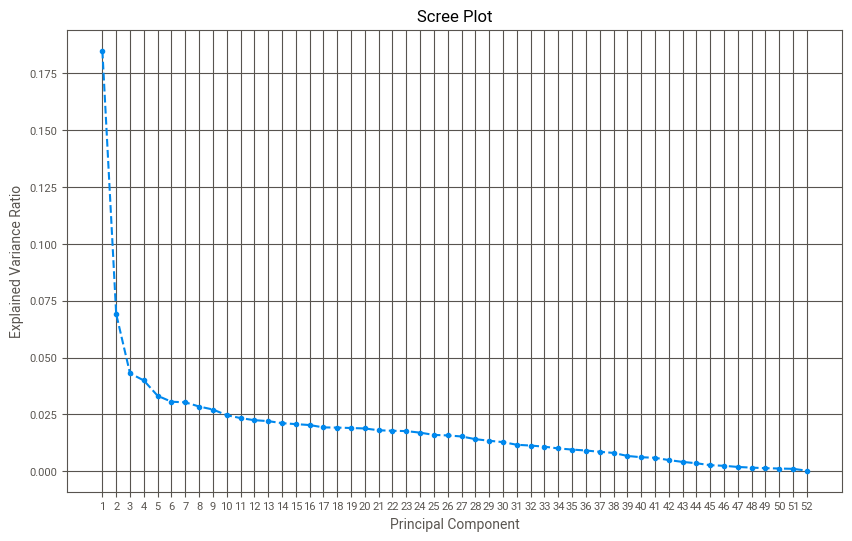

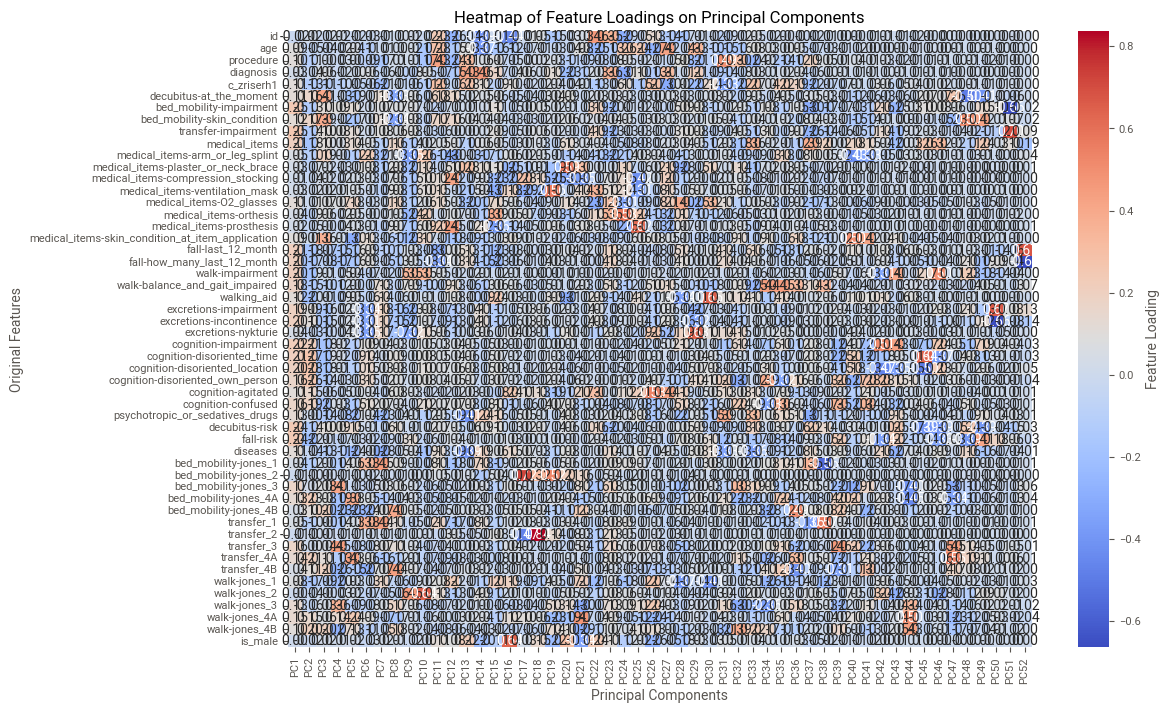

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Separate the target variable and features
y = df['fallen']  # Preserve the target variable
X = df.drop(columns=['fallen'], errors='ignore')  # Drop target column for PCA

# Step 2: Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Step 3: Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_normalized)

# Step 4: Extract explained variance ratio and eigenvalues
explained_variance_ratio = pca.explained_variance_ratio_
eigenvalues = pca.components_

# Step 5: Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid()
plt.show()

# Step 6: Heatmap of Feature Loadings
# Create a DataFrame for the eigenvalues (feature loadings)
loadings_df = pd.DataFrame(eigenvalues.T, index=X.columns, columns=[f'PC{i+1}' for i in range(len(eigenvalues))])

plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Feature Loading'})
plt.title('Heatmap of Feature Loadings on Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.show()

In [90]:
n_components = 10  # Replace with the number of PCs you decide to retain
pca_reduced = PCA(n_components=n_components)
X_reduced = pca_reduced.fit_transform(X_normalized)

In [ ]:
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 1: Prepare the reduced dataset
# Assuming `X_reduced` is the PCA-reduced dataset and `y` is the target variable
X_reduced_df = pd.DataFrame(X_reduced, columns=[f'PC{i+1}' for i in range(X_reduced.shape[1])])
reduced_dataset = pd.concat([X_reduced_df, y.reset_index(drop=True)], axis=1)

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(reduced_dataset, test_size=0.2, random_state=42)

# Step 2: Set up AutoGluon
# Specify the target column
target_column = 'fallen'

# Step 3: Train multiple models
predictor = TabularPredictor(label=target_column, eval_metric='accuracy').fit(
    train_data=train_data,
    time_limit=600,  # Set a time limit for training (in seconds)
    presets='best_quality'  # Use high-quality presets for better performance
)

# Step 4: Evaluate models
# Generate a leaderboard to compare models
leaderboard = predictor.leaderboard(test_data, silent=True)

# Display the leaderboard
print("Model Leaderboard:")
print(leaderboard)

# Step 5: Select the best model
# The best model is automatically selected by AutoGluon
best_model = predictor.get_model_best()
print(f"The best model is: {best_model}")

# Step 6: Evaluate the best model on the test set
test_predictions = predictor.predict(test_data.drop(columns=[target_column]))
test_scores = predictor.evaluate_predictions(
    y_true=test_data[target_column],
    y_pred=test_predictions,
    auxiliary_metrics=True
)

print("Test Set Evaluation Metrics:")
print(test_scores)

No path specified. Models will be saved in: "AutogluonModels\ag-20250324_204739"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.9.21
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          24
Memory Avail:       21.35 GB / 31.92 GB (66.9%)
Disk Space Avail:   99.64 GB / 931.51 GB (10.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout 

In [ ]:
# get correlations


from sklearn.preprocessing import LabelEncoder

# Create a copy of the DataFrame to avoid modifying the original
df_encoded = df.copy()

# Encode non-numerical columns using LabelEncoder
for column in df_encoded.select_dtypes(include=["object", "category"]).columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column].astype(str))  # Convert to string before encoding

# Identify columns with mixed types and convert them to strings before encoding
for column in df_encoded.columns:
    if df_encoded[column].apply(type).nunique() > 1:  # Check for mixed types
        df_encoded[column] = df_encoded[column].astype(str)

# Calculate the correlation of each column with the binary outcome variable 'fallen'
correlations = df_encoded.corr()["fallen"].drop("fallen")

# Sort the correlations in descending order
sorted_correlations = correlations.sort_values(ascending=False)

# Display the sorted correlations
print("Sorted correlations with 'fallen':")
print(sorted_correlations)

In [ ]:
# drop columns with low correlation


# Define a threshold for low correlation
correlation_threshold = 0.05

# Identify columns with correlation below the threshold
low_correlation_columns = sorted_correlations[sorted_correlations.abs() < correlation_threshold].index.tolist()

# Drop these columns from the DataFrame
df_reduced = df.drop(columns=low_correlation_columns)

# Print the dropped columns for reference
print(f"Dropped columns due to low correlation: {low_correlation_columns}")

Dropped columns due to low correlation: ['bed_mobility-jones_4A', 'excretions-nykturie', 'procedure', 'walk-jones_4B', 'c_zriserh1', 'medical_items-orthesis', 'is_male', 'psychotropic_or_sedatives_drugs', 'diagnosis', 'bed_mobility-jones_4B', 'transfer_4B', 'medical_items-ventilation_mask', 'medical_items-compression_stocking', 'medical_items-prosthesis', 'medical_items-plaster_or_neck_brace', 'medical_items-arm_or_leg_splint', 'bed_mobility-jones_2', 'transfer_2', 'walk-jones_2', 'id']
